# Imports + check GPU + chemins

In [25]:
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import mixed_precision
import matplotlib.pyplot as plt

# === OPTIM: Mixed Precision (A100 / Tensor Cores) ===
mixed_precision.set_global_policy("mixed_float16")
print("Mixed precision policy:", mixed_precision.global_policy())

print("TensorFlow version:", tf.__version__)
print("Keras version:", keras.__version__)

# Vérifier si un GPU est visible par TensorFlow
print("TF version:", tf.__version__)
print("Build with CUDA:", tf.test.is_built_with_cuda())
gpus = tf.config.list_physical_devices("GPU")
print("GPUs:", gpus)

# Petit test rapide: faire un calcul sur GPU si dispo
with tf.device('/GPU:0' if tf.config.list_physical_devices("GPU") else '/CPU:0'):
    a = tf.random.normal([2000, 2000])
    b = tf.random.normal([2000, 2000])
    c = tf.matmul(a, b)
print("OK, matmul done. Device used should be GPU if available.")

if not gpus:
    print(" Aucun GPU détecté.")
else:
    # (Optionnel) Activer la croissance mémoire pour éviter certains crash OOM
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(" GPU actif et memory growth activé.")
    except Exception as e:
        print("GPU actif, mais impossible d'activer memory growth:", e)

# Kaggle : datasets montés ici (en général)
#print("\nContenu de ./train :")
#print(os.listdir("./train"))


Mixed precision policy: <DTypePolicy "mixed_float16">
TensorFlow version: 2.19.0
Keras version: 3.10.0
TF version: 2.19.0
Build with CUDA: True
GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
OK, matmul done. Device used should be GPU if available.
GPU actif, mais impossible d'activer memory growth: Physical devices cannot be modified after being initialized


# Préparation des données

***Définir les chemins***

In [ ]:
# Google Colab : monter Google Drive (uniquement si on est sur Colab en ligne)
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
import os
zip_file = './DataSet_AffectNet.zip'#"/content/drive/MyDrive/DataSet_AffectNet.zip" (lien Google Drive pour Colab en ligne)
output_dir = "DataSet_AffectNet"  # Il vaut mieux un nom clair

# 1. Dézippage
print(f" Décompression de {zip_file}...")
with zipfile.ZipFile(zip_file, "r") as zip_ref:
    zip_ref.extractall(output_dir)
print(" Décompression terminée.\n")

# 2. Exploration de la structure (Arborescence)
print(f" Structure du dossier '{output_dir}':")

 Décompression de /content/drive/MyDrive/DataSet_AffectNet.zip...
 Décompression terminée.

 Structure du dossier 'DataSet_AffectNet':


In [30]:
!ls DataSet_AffectNet


Test  Train


In [33]:
!ls DataSet_AffectNet/Test


Anger  Contempt  disgust  fear	happy  neutral	sad  surprise


In [62]:
import os

train_dir = "DataSet_AffectNet/Train"
test_dir  = "DataSet_AffectNet/Test"  # si tu as un dossier test, sinon laisse mais on ne l'utilisera pas

print("Train exists:", os.path.exists(train_dir), train_dir)
print("Test exists :", os.path.exists(test_dir),  test_dir)
print("Classes train:", sorted(os.listdir(train_dir)))


Train exists: True DataSet_AffectNet/Train
Test exists : True DataSet_AffectNet/Test
Classes train: ['anger', 'contempt', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


**dimension des images**

In [67]:
from PIL import Image
from pathlib import Path
from collections import Counter

image_dir = Path(train_dir)

sizes = []

for img_path in image_dir.rglob("*"):
    if img_path.suffix.lower() in [".jpg", ".jpeg", ".png"]:
        with Image.open(img_path) as img:
            sizes.append(img.size)  # (width, height)

print('dimension des images',Counter(sizes))


dimension des images Counter({(96, 96): 16108})


***Data Augmentation + générateurs***

In [68]:
from tensorflow.keras.applications.resnet import preprocess_input
import tensorflow as tf
import os

IMG_SIZE = (96, 96)
BATCH_SIZE = 32  # sur Colab GPU: 32 (si erreur mémoire -> 16)
AUTOTUNE = tf.data.AUTOTUNE

# === OPTIM: Pipeline tf.data + cache RAM (plus rapide que ImageDataGenerator) ===
# 1) On charge depuis le dossier
train_ds_raw = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical",
    shuffle=True
)

val_ds_raw = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical",
    shuffle=False
)

class_names = train_ds_raw.class_names
NUM_CLASSES = len(class_names)

# 2) Preprocessing ResNet (remplace preprocessing_function=preprocess_input)
def _preprocess(x, y):
    x = tf.cast(x, tf.float32)
    x = preprocess_input(x)  # ResNet50 expects this
    return x, y

# 3) Cache RAM + prefetch
train_ds = (
    train_ds_raw
    .map(_preprocess, num_parallel_calls=AUTOTUNE)
    .cache()                 # <-- cache en RAM
    .shuffle(1000)           # shuffle après cache pour reshuffle à chaque epoch
    .prefetch(AUTOTUNE)
)

val_ds = (
    val_ds_raw
    .map(_preprocess, num_parallel_calls=AUTOTUNE)
    .cache()                 # <-- cache en RAM
    .prefetch(AUTOTUNE)
)

# (Optionnel) Test dataset
test_ds = None
if os.path.exists(test_dir):
    test_ds_raw = tf.keras.utils.image_dataset_from_directory(
        test_dir,
        image_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        label_mode="categorical",
        shuffle=False
    )
    test_ds = (
        test_ds_raw
        .map(_preprocess, num_parallel_calls=AUTOTUNE)
        .cache()
        .prefetch(AUTOTUNE)
    )

print("Train batches:", tf.data.experimental.cardinality(train_ds).numpy())
print("Val batches  :", tf.data.experimental.cardinality(val_ds).numpy())
print("Test batches :", tf.data.experimental.cardinality(test_ds).numpy() if test_ds else "No test folder")
print("Classes:", class_names)


Found 16108 files belonging to 8 classes.
Using 12887 files for training.
Found 16108 files belonging to 8 classes.
Using 3221 files for validation.
Found 14518 files belonging to 8 classes.
Train batches: 403
Val batches  : 101
Test batches : 454
Classes: ['anger', 'contempt', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


***afficher un batch d’images***

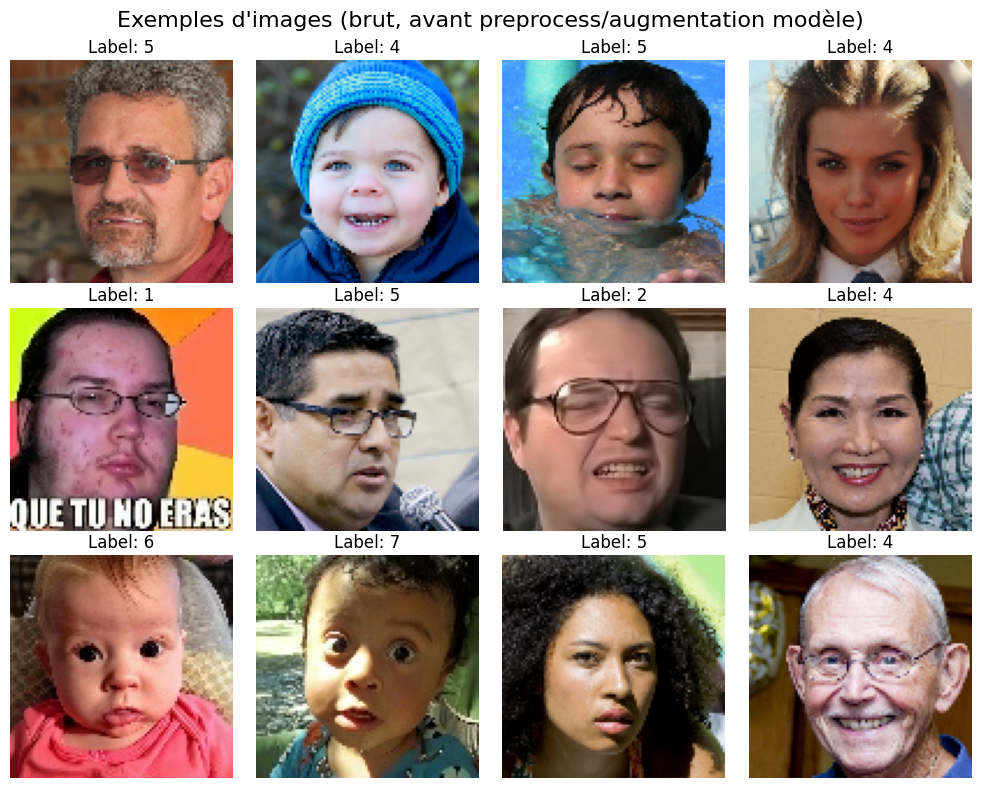

In [69]:
# On récupère un batch (avant augmentation modèle, mais après chargement)
images, labels = next(iter(train_ds_raw))

plt.figure(figsize=(10, 8))
for i in range(12):
    plt.subplot(3, 4, i+1)
    img = images[i].numpy().astype("uint8")
    plt.imshow(img)
    plt.title(f"Label: {labels[i].numpy().argmax()}")
    plt.axis("off")

plt.suptitle("Exemples d'images (brut, avant preprocess/augmentation modèle)", fontsize=16)
plt.tight_layout()
plt.show()


# Construction du modèle ResNet (Transfer Learning)

***Charger ResNet50 (ImageNet) sans le “top”***

In [70]:
base_model = keras.applications.ResNet50(
    weights="imagenet",
    include_top=False,
    input_shape=(96, 96, 3)
)
#base_model.summary()

base_model.trainable = False  # IMPORTANT (CPU): on gèle la base au début


In [71]:
len(base_model.layers)

175

***Ajouter la tête personnalisée (GAP + Dense + Dropout + Softmax)***

In [72]:
# === OPTIM (amélioration): Data augmentation DANS le modèle ===
# Pourquoi: avec tf.data + cache(), l'augmentation n'est plus gérée par ImageDataGenerator.
# On la met ici pour qu'elle s'applique seulement pendant l'entraînement, et qu'elle soit GPU-accélérée.

inputs = keras.Input(shape=(96, 96, 3))

# Augmentations adaptées au FER (faciales) :
# - Flip horizontal: OK (visages symétriques)
# - Petite rotation/zoom: évite de "casser" l'expression
# - Contrast: aide avec variations de lumière/caméra
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.05),
    layers.RandomContrast(0.2),
], name="data_augmentation")

x = data_augmentation(inputs)

# Backbone
x = base_model(x, training=False)  # preprocess_input est fait dans le tf.data pipeline
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(512, activation="relu")(x)
x = layers.Dropout(0.5)(x)

# IMPORTANT (mixed precision): sortir en float32 pour stabilité numérique
outputs = layers.Dense(NUM_CLASSES, activation="softmax", dtype="float32")(x)

model = keras.Model(inputs, outputs)


***Compilation***

In [73]:
# === OPTIM (amélioration): Label Smoothing ===
# Pourquoi: en classification (surtout FER), le modèle devient vite trop "sûr" de lui (overconfident).
# Le label smoothing améliore la généralisation et stabilise l'entraînement.
loss_fn = keras.losses.CategoricalCrossentropy(label_smoothing=0.1)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss=loss_fn,
    metrics=["accuracy"]
)

print("Classes (train):", class_names)
print("NUM_CLASSES:", NUM_CLASSES)

model.summary()


Classes (train): ['anger', 'contempt', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
NUM_CLASSES: 8


Model: "functional_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)     │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 3, 3, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 8)              │         4,104 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,640,904 (94.00 MB)

 Trainable params: 1,053,192 (4.02 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

***Callbacks***

In [74]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.2,
    patience=3,
    min_lr=1e-7,
    verbose=1
)

checkpoint = ModelCheckpoint(
    "best_resnet50_fer.keras",
    monitor="val_loss",
    save_best_only=True,
    verbose=1
)

callbacks = [early_stop, reduce_lr, checkpoint]


# Entrainement

***Lancer l’entraînement (20–50 époques)***

In [75]:
# === OPTIM (amélioration): Class Weights pour gérer le déséquilibre des classes ===
# Pourquoi: FER est souvent déséquilibré (beaucoup de 'neutral/happy', peu de 'disgusted/fearful').
# Sans class_weight, le modèle apprend à privilégier les classes majoritaires.
import numpy as np
from collections import Counter

y = []
for _, labels in train_ds_raw:  # dataset "brut" (sans augmentation), mêmes labels
    y.extend(np.argmax(labels.numpy(), axis=1))

counts = Counter(y)
n_classes = len(class_names)
total = sum(counts.values())

class_weight = {cls: total / (n_classes * count) for cls, count in counts.items()}

print("Counts par classe:")
for i, name in enumerate(class_names):
    print(f"  {i} ({name}): {counts.get(i, 0)}  -> weight={class_weight.get(i, 0):.3f}")


Counts par classe:
  0 (anger): 1207  -> weight=1.335
  1 (contempt): 1259  -> weight=1.279
  2 (disgust): 991  -> weight=1.626
  3 (fear): 1209  -> weight=1.332
  4 (happy): 1857  -> weight=0.867
  5 (neutral): 2219  -> weight=0.726
  6 (sad): 2423  -> weight=0.665
  7 (surprise): 1722  -> weight=0.935


In [76]:
# === Phase 1: entraînement de la tête (backbone gelé) ===
EPOCHS = 50  # 20 à 50

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks,
    class_weight=class_weight  # <-- améliore les classes rares
)


Epoch 1/50
401/403 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.1910 - loss: 2.8331
Epoch 1: val_loss improved from inf to 1.94621, saving model to best_resnet50_fer.keras
403/403 ━━━━━━━━━━━━━━━━━━━━ 23s 31ms/step - accuracy: 0.1912 - loss: 2.8295 - val_accuracy: 0.2651 - val_loss: 1.9462 - learning_rate: 1.0000e-04
Epoch 2/50
402/403 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.2820 - loss: 1.9268
Epoch 2: val_loss improved from 1.94621 to 1.87813, saving model to best_resnet50_fer.keras
403/403 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - accuracy: 0.2820 - loss: 1.9268 - val_accuracy: 0.2990 - val_loss: 1.8781 - learning_rate: 1.0000e-04
Epoch 3/50
400/403 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.3123 - loss: 1.8794
Epoch 3: val_loss improved from 1.87813 to 1.85264, saving model to best_resnet50_fer.keras
403/403 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - accuracy: 0.3123 - loss: 1.8794 - val_accuracy: 0.2726 - val_loss: 1.8526 - learning_rate: 1.0000e-04
Epoch 4/50
403/403 ━━━━━━━━━

In [77]:
# === Phase 2 (très important): Fine-tuning partiel de ResNet50 ===
# Pourquoi: la phase 1 apprend surtout un classifieur sur des features ImageNet.
# Le fine-tuning (avec LR très petit) adapte les dernières couches aux expressions faciales
# -> souvent +5 à +15 points de val_accuracy.

import tensorflow as tf

# Charger le meilleur checkpoint de la phase 1
model = tf.keras.models.load_model("best_resnet50_fer.keras")

#  Cibler explicitement le backbone ResNet50
backbone = model.get_layer("resnet50")

print("Backbone détecté:", backbone.name if backbone else "AUCUN")

# Défreezer seulement les ~30 dernières couches pour éviter d'abîmer les features génériques
if backbone is not None:
    backbone.trainable = True
    for l in backbone.layers[:-30]:
        l.trainable = False

# Cosine decay = descente progressive du LR (souvent plus stable que ReduceLROnPlateau en fine-tune)
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
ft_epochs = 30
lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=1e-5,
    decay_steps=steps_per_epoch * ft_epochs,
    alpha=1e-2
)

# On garde le même loss label_smoothing
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    loss=loss_fn,
    metrics=["accuracy"]
)

# Callbacks pour fine-tune: checkpoint + early stopping (on enlève ReduceLROnPlateau car LR est piloté)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

ft_checkpoint = ModelCheckpoint(
    "best_resnet50_fer_finetuned.keras",
    monitor="val_loss",
    save_best_only=True,
    verbose=1
)
ft_early = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

history_ft = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=ft_epochs,
    callbacks=[ft_early, ft_checkpoint],
    class_weight=class_weight
)

print("✅ Fine-tuning terminé. Meilleur modèle:", "best_resnet50_fer_finetuned.keras")


Backbone détecté: resnet50
Epoch 1/30
403/403 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.2802 - loss: 1.9451
Epoch 1: val_loss improved from inf to 1.79721, saving model to best_resnet50_fer_finetuned.keras
403/403 ━━━━━━━━━━━━━━━━━━━━ 38s 53ms/step - accuracy: 0.2802 - loss: 1.9450 - val_accuracy: 0.3511 - val_loss: 1.7972
Epoch 2/30
403/403 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.3442 - loss: 1.8080
Epoch 2: val_loss improved from 1.79721 to 1.75729, saving model to best_resnet50_fer_finetuned.keras
403/403 ━━━━━━━━━━━━━━━━━━━━ 16s 39ms/step - accuracy: 0.3442 - loss: 1.8079 - val_accuracy: 0.3670 - val_loss: 1.7573
Epoch 3/30
403/403 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.3723 - loss: 1.7309
Epoch 3: val_loss improved from 1.75729 to 1.72644, saving model to best_resnet50_fer_finetuned.keras
403/403 ━━━━━━━━━━━━━━━━━━━━ 16s 39ms/step - accuracy: 0.3723 - loss: 1.7309 - val_accuracy: 0.3831 - val_loss: 1.7264
Epoch 4/30
403/403 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step 

# **Évaluation (courbes + matrice de confusion)**
# *Courbes d'apprentissage (Loss / Accuracy)*

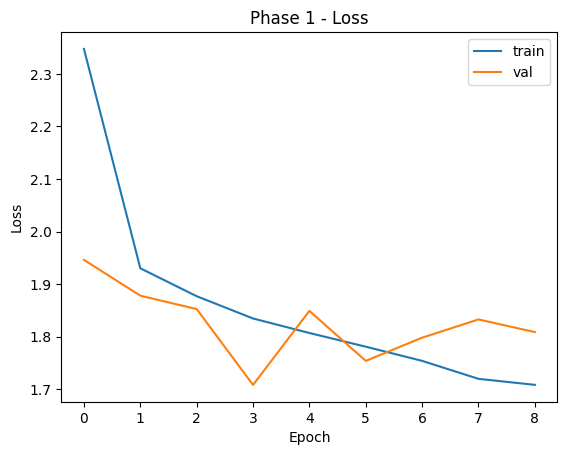

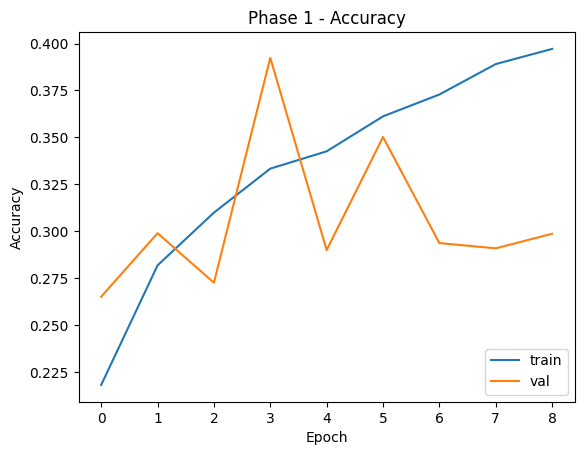

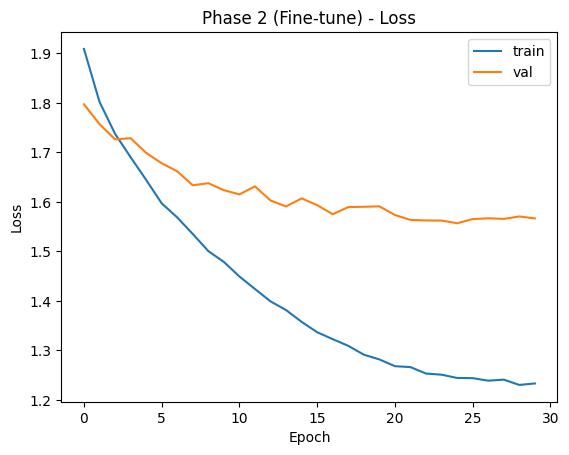

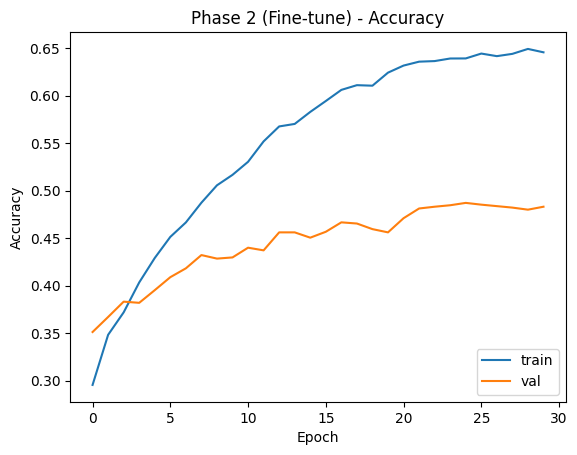

In [78]:
# Courbes d'apprentissage (Loss / Accuracy)
# ✅ Affiche les courbes pour Phase 1 et Phase 2 si les variables existent:
# - history (ou history_phase1)
# - history_ft (fine-tuning)

import matplotlib.pyplot as plt

def plot_history(hist, title_prefix=""):
    if hist is None:
        return
    h = hist.history if hasattr(hist, "history") else hist
    if "loss" in h:
        plt.figure()
        plt.plot(h["loss"])
        if "val_loss" in h:
            plt.plot(h["val_loss"])
        plt.title(f"{title_prefix}Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend(["train", "val"], loc="upper right")
        plt.show()

    if "accuracy" in h:
        plt.figure()
        plt.plot(h["accuracy"])
        if "val_accuracy" in h:
            plt.plot(h["val_accuracy"])
        plt.title(f"{title_prefix}Accuracy")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.legend(["train", "val"], loc="lower right")
        plt.show()

history_phase1 = globals().get("history", None) or globals().get("history_phase1", None)
history_phase2 = globals().get("history_ft", None) or globals().get("history_phase2", None)

plot_history(history_phase1, title_prefix="Phase 1 - ")
plot_history(history_phase2, title_prefix="Phase 2 (Fine-tune) - ")


# Sélection automatique du "meilleur" modèle à utiliser






In [79]:
# Explication:
# - On compare les meilleures métriques de validation trouvées dans les historiques
# - Puis on vérifie en évaluant directement chaque modèle sur val_ds (plus fiable)

import numpy as np
import tensorflow as tf
import os

PHASE1_PATH = "best_resnet50_fer.keras"
PHASE2_PATH = "best_resnet50_fer_finetuned.keras"

def best_from_history(hist):
    if hist is None or not hasattr(hist, "history"):
        return None
    h = hist.history
    best = {}
    if "val_loss" in h:
        best_epoch = int(np.argmin(h["val_loss"])) + 1
        best["best_val_loss"] = float(np.min(h["val_loss"]))
        best["best_val_loss_epoch"] = best_epoch
    if "val_accuracy" in h:
        best_epoch = int(np.argmax(h["val_accuracy"])) + 1
        best["best_val_accuracy"] = float(np.max(h["val_accuracy"]))
        best["best_val_accuracy_epoch"] = best_epoch
    return best

b1 = best_from_history(history_phase1)
b2 = best_from_history(history_phase2)

print("📌 Résumé depuis les historiques (si disponibles)")
print("Phase 1:", b1)
print("Phase 2:", b2)

def eval_model(path, ds):
    if not os.path.exists(path):
        return None
    m = tf.keras.models.load_model(path)
    results = m.evaluate(ds, verbose=0)
    names = m.metrics_names
    return dict(zip(names, [float(x) for x in results]))

print("\n📌 Évaluation directe sur val_ds (plus fiable)")
phase1_eval = eval_model(PHASE1_PATH, val_ds) if "val_ds" in globals() else None
phase2_eval = eval_model(PHASE2_PATH, val_ds) if "val_ds" in globals() else None
print("Phase 1 eval:", phase1_eval)
print("Phase 2 eval:", phase2_eval)

# Choix automatique basé sur val_loss si disponible
chosen = None
reason = ""
if phase1_eval and phase2_eval and ("loss" in phase1_eval) and ("loss" in phase2_eval):
    if phase2_eval["loss"] < phase1_eval["loss"]:
        chosen = PHASE2_PATH
        reason = "val_loss plus basse en Phase 2"
    else:
        chosen = PHASE1_PATH
        reason = "val_loss plus basse en Phase 1"
else:
    # fallback: si pas d'éval, choisir Phase 2 si elle existe
    chosen = PHASE2_PATH if os.path.exists(PHASE2_PATH) else PHASE1_PATH
    reason = "fallback (fichier disponible)"

print(f"\n Modèle recommandé: {chosen}  ({reason})")


📌 Résumé depuis les historiques (si disponibles)
Phase 1: {'best_val_loss': 1.7084459066390991, 'best_val_loss_epoch': 4, 'best_val_accuracy': 0.39242470264434814, 'best_val_accuracy_epoch': 4}
Phase 2: {'best_val_loss': 1.556942343711853, 'best_val_loss_epoch': 25, 'best_val_accuracy': 0.4871158003807068, 'best_val_accuracy_epoch': 25}

📌 Évaluation directe sur val_ds (plus fiable)
Phase 1 eval: {'loss': 1.7084459066390991, 'compile_metrics': 0.39242470264434814}
Phase 2 eval: {'loss': 1.556942343711853, 'compile_metrics': 0.4871158003807068}

 Modèle recommandé: best_resnet50_fer_finetuned.keras  (val_loss plus basse en Phase 2)


# *Matrice de confusion*

Validation sur le dataset 'test' (test_ds)...


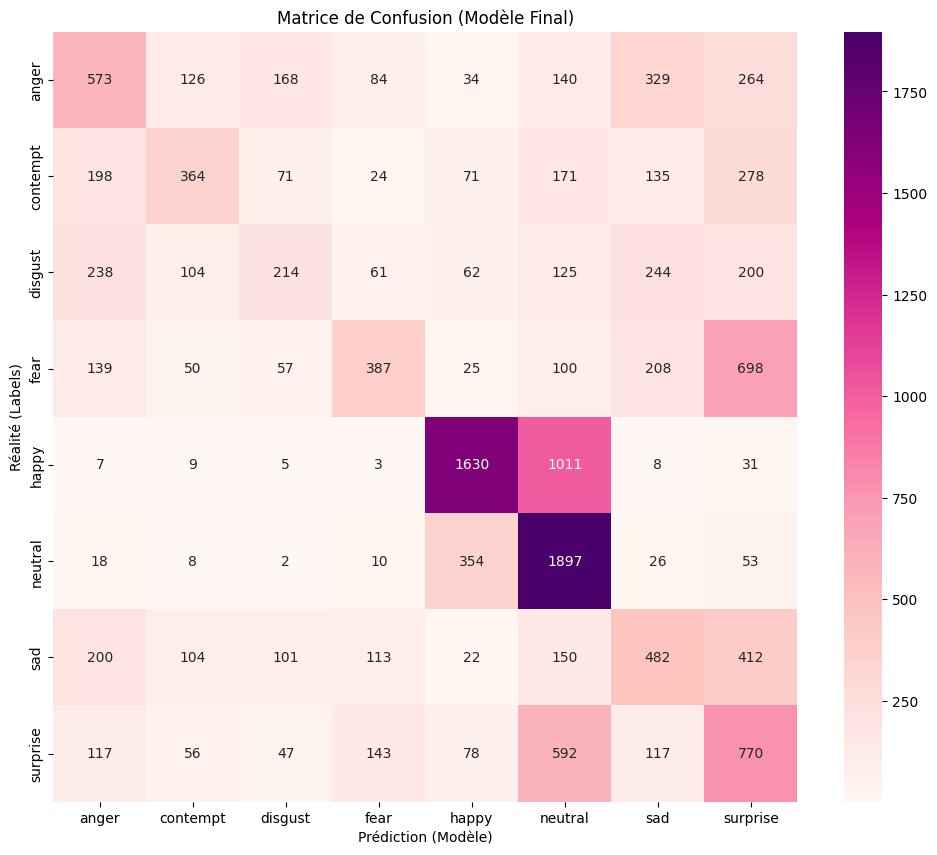


--- Rapport de Classification ---
              precision    recall  f1-score   support

       anger       0.38      0.33      0.36      1718
    contempt       0.44      0.28      0.34      1312
     disgust       0.32      0.17      0.22      1248
        fear       0.47      0.23      0.31      1664
       happy       0.72      0.60      0.65      2704
     neutral       0.45      0.80      0.58      2368
         sad       0.31      0.30      0.31      1584
    surprise       0.28      0.40      0.33      1920

    accuracy                           0.44     14518
   macro avg       0.42      0.39      0.39     14518
weighted avg       0.45      0.44      0.42     14518



In [80]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# 1. Extraction des vrais labels et prédictions
print("Validation sur le dataset 'test' (test_ds)...")

# On récupère tous les labels du dataset de validation (test_ds)
# .unbatch() permet de traiter les images une par une pour la matrice
y_true = []
y_pred = []

# On utilise le modèle chargé (le meilleur)
for images, labels in test_ds:
    preds = model.predict(images, verbose=0)

    # On stocke les vrais labels (argmax car ils sont en One-Hot dans ton notebook)
    y_true.extend(np.argmax(labels, axis=1))

    # On stocke les prédictions
    y_pred.extend(np.argmax(preds, axis=1))

# 2. Création de la matrice de confusion
cm = confusion_matrix(y_true, y_pred)

# 3. Affichage graphique
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='RdPu', # RdPu est joli pour les émotions
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Matrice de Confusion (Modèle Final)')
plt.ylabel('Réalité (Labels)')
plt.xlabel('Prédiction (Modèle)')
plt.show()

# 4. Rapport détaillé
print("\n--- Rapport de Classification ---")
print(classification_report(y_true, y_pred, target_names=class_names))

Télécharger le meilleur modèle (checkpoint)

In [81]:
from google.colab import files
#files.download('best_resnet50_fer.keras')#chosen)
files.download(chosen)



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Sauver aussi l’ordre des classes (TRÈS IMPORTANT)

In [58]:
import json
from google.colab import files

with open("class_names.json", "w") as f:
    json.dump(class_names, f)

files.download("class_names.json")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [82]:
print(class_names)


['anger', 'contempt', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
